# File for checking import and first visualization
cifar consists of 5 batches (downloaded from http://www.cs.toronto.edu/~kriz/cifar.html)
data is stored in data/cifar/cifar-10-batches-by
code for automatic download in solution from deep-diver (uncommented)

In [76]:
import numpy as np
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt
import cv2
# import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import os
from cv2 import xfeatures2d
import time 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, ConfusionMatrixDisplay, precision_score, make_scorer


In [2]:
# pip install opencv-contrib-python --user

In [111]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## own solution

### Dataset importing

In [4]:
def unpickle(file):
    """
    returns a  from cifar data
    :param file:
    :return:
    """
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [8]:
def load_train_test_data(path_to_data='data/cifar/cifar-10-batches-py'):
    """
    :param path_to_data: path to
    :return: X_train, y_train, X_test, y_test, label_names
    """

    dict_b1 = unpickle(path_to_data + "/data_batch_1")
    dict_b2 = unpickle(path_to_data + "/data_batch_2")
    dict_b3 = unpickle(path_to_data + "/data_batch_3")
    dict_b4 = unpickle(path_to_data + "/data_batch_4")
    dict_b5 = unpickle(path_to_data + "/data_batch_5")
    dict_meta = unpickle(path_to_data + "/batches.meta")
    dict_test = unpickle(path_to_data + "/test_batch")

    data_b1 = dict_b1[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2,3,1)
    data_b2 = dict_b2[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2,3,1)
    data_b3 = dict_b3[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2,3,1)
    data_b4 = dict_b4[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2,3,1)
    data_b5 = dict_b5[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2,3,1)
    labels_b1 = dict_b1[b'labels']
    labels_b2 = dict_b2[b'labels']
    labels_b3 = dict_b3[b'labels']
    labels_b4 = dict_b4[b'labels']
    labels_b5 = dict_b5[b'labels']


    X_test = dict_test[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2,3,1)
    y_test = np.array(dict_test[b'labels'])
    X_train = np.concatenate([data_b1, data_b2, data_b3, data_b4, data_b5])
    y_train = np.concatenate([labels_b1, labels_b2, labels_b3, labels_b4, labels_b5])
    label_names = dict_meta[b'label_names']
    label_names = [name.decode('utf-8') for name in label_names]  # encode (remove b'')

    return X_train, y_train, X_test, y_test, label_names



In [9]:
X_train, y_train, X_test, y_test, label_names = load_train_test_data()

In [10]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (50000, 32, 32, 3)
Shape of y_train: (50000,)
Shape of X_test: (10000, 32, 32, 3)
Shape of y_test: (10000,)


In [11]:
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1,1))
y_test_encoded = encoder.transform(y_test.reshape(-1,1))

In [12]:
print("Shape of y_train_encoded:", y_train_encoded.shape)
print("Shape of y_test_encoded:", y_test_encoded.shape)

Shape of y_train_encoded: (50000, 10)
Shape of y_test_encoded: (10000, 10)


In [13]:
print("Training set")
num_classes = len(np.unique(y_train))
num_per_class = np.zeros(num_classes)
for i in range(0, num_classes):
    num_per_class[i] = len(y_train == i)
    print("Class", i, "-", label_names[i], ":", int(num_per_class[i]), "images")

print("_______________________________")
print("Testing set")
num_classes = len(np.unique(y_test))
num_per_class_test = np.zeros(num_classes)
for i in range(0, num_classes):
    num_per_class_test[i] = len(y_test == i)
    print("Class", i, "-", label_names[i], ":", int(num_per_class_test[i]), "images")


Training set
Class 0 - airplane : 50000 images
Class 1 - automobile : 50000 images
Class 2 - bird : 50000 images
Class 3 - cat : 50000 images
Class 4 - deer : 50000 images
Class 5 - dog : 50000 images
Class 6 - frog : 50000 images
Class 7 - horse : 50000 images
Class 8 - ship : 50000 images
Class 9 - truck : 50000 images
_______________________________
Testing set
Class 0 - airplane : 10000 images
Class 1 - automobile : 10000 images
Class 2 - bird : 10000 images
Class 3 - cat : 10000 images
Class 4 - deer : 10000 images
Class 5 - dog : 10000 images
Class 6 - frog : 10000 images
Class 7 - horse : 10000 images
Class 8 - ship : 10000 images
Class 9 - truck : 10000 images


### Dataset visualizations

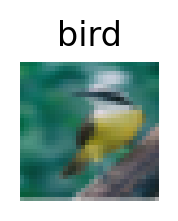

In [12]:
# Choose an index to select an image from the dataset
index = 27001

# Set the figure size
plt.figure(figsize=(0.9, 0.9))

# Get the image and label
image = X_train[index]
label = y_train[index]

# Plot the image
plt.imshow(image)
plt.title(label_names[label])
plt.axis('off')
plt.show()

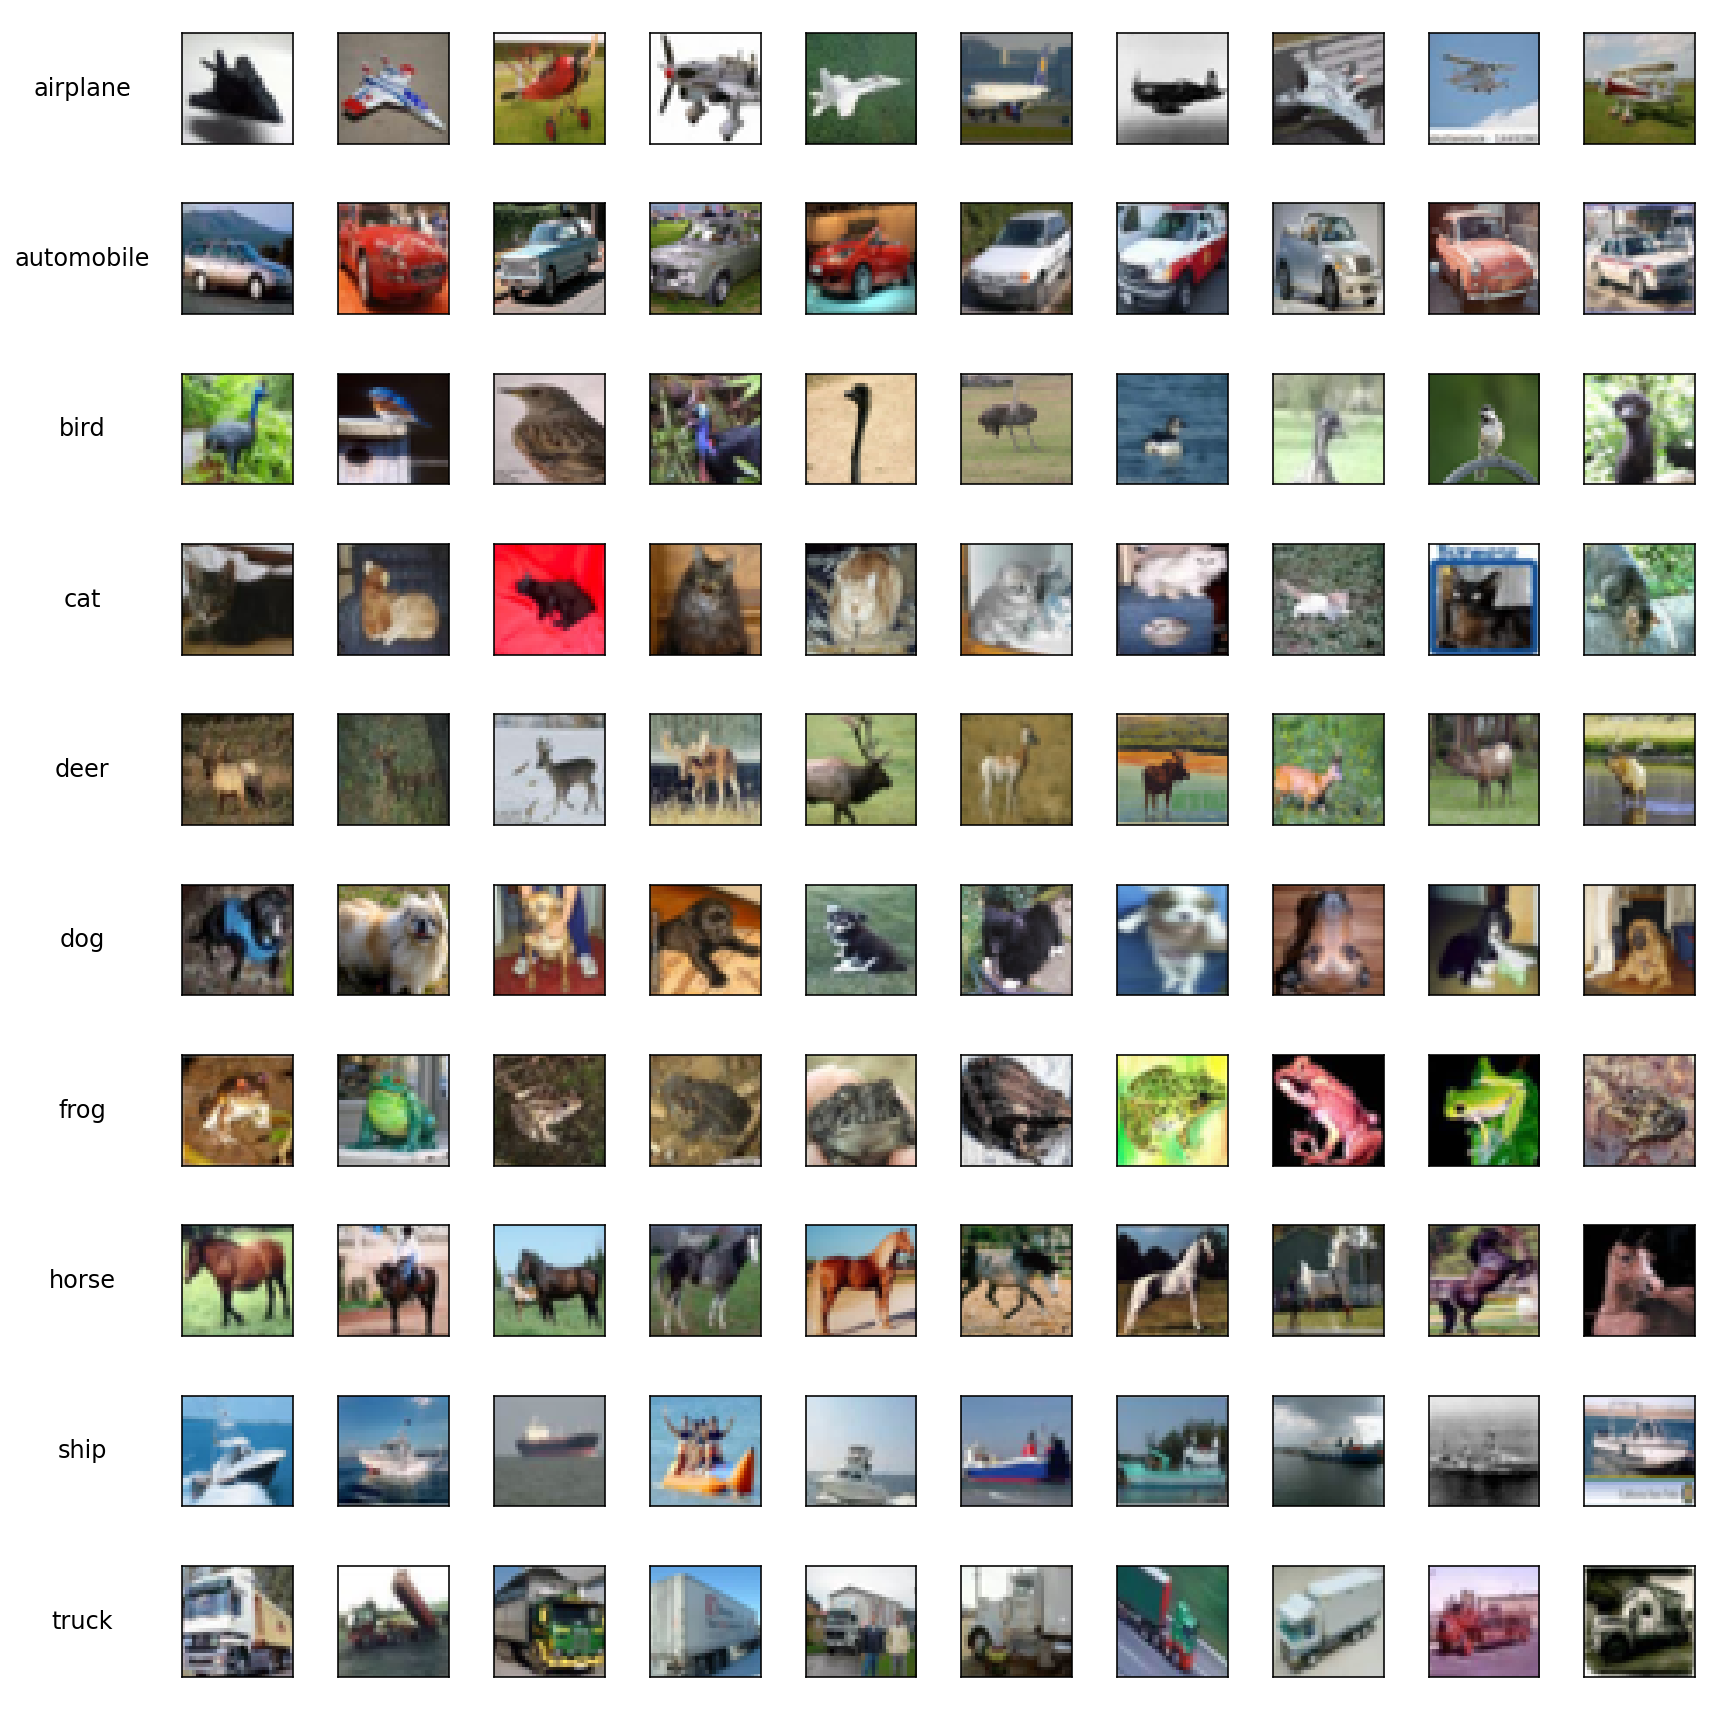

In [12]:
fig, ax = plt.subplots(nrows=num_classes, ncols=11, figsize=(12, 12))

for i in range(0, num_classes):
    indices = np.where(y_train == i)[0]
    indices = indices[:10] # first 10 images belonging to i-th class 
    for j in range(0, 10):
        img = X_train[indices[j], :, :, :]
        ax[i, j+1].imshow(img)
        ax[i, j+1].set_xticks([]); ax[i, j+1].set_yticks([])
        ax[i, j+1].set_xticklabels([]); ax[i, j+1].set_yticklabels([])
    ax[i, 0].text(0.5, 0.5, label_names[i], fontsize=12, ha='center', va='center')
    ax[i, 0].set_xticks([]); ax[i, 0].set_yticks([])
    ax[i, 0].set_xticklabels([]); ax[i, 0].set_yticklabels([])

    # remove frame of the plot by setting spines visibility to False
    for spine in ax[i, 0].spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.show()

### "Traditional" feature extraction methods: 1. colour histogram

In [39]:
def calculate_color_histogram(index, num_bins=256):
    img = X_train[index]

    # RGB color space
    r = img[:, :, 0] # first RGB plane corresponds to red color channel -> shape: (32, 32)
    g = img[:, :, 1] # second RGB plane corresponds to green color channel
    b = img[:, :, 2] # third RGB plane corresponds to blue color channel

    # compute the histograms for the all image channel
    hist_r, _ = np.histogram(r, bins=num_bins, range=(0, num_bins))
    hist_g, _ = np.histogram(g, bins=num_bins, range=(0, num_bins))
    hist_b, _ = np.histogram(b, bins=num_bins, range=(0, num_bins))

    # convert histograms to floating-point type before normalization
    hist_r = hist_r.astype(np.float32)
    hist_g = hist_g.astype(np.float32)
    hist_b = hist_b.astype(np.float32)

    hist_r /= hist_r.sum()
    hist_g /= hist_g.sum()
    hist_b /= hist_b.sum()

    return hist_r, hist_g, hist_b

In [40]:
# Plot color histograms and R, G, B channels as grayscale images
def plot_rgb(r_hist, g_hist, b_hist, index):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

    ax[0, 0].imshow(X_train[index]); ax[0, 0].set_xticks([]); ax[0, 0].set_yticks([]); ax[0, 0].set_title('RGB image')
    ax[0, 1].imshow(X_train[index]); ax[0, 1].set_xticks([]); ax[0, 1].set_yticks([]); ax[0, 1].set_title('RGB image')
    ax[0, 2].imshow(X_train[index]); ax[0, 2].set_xticks([]); ax[0, 2].set_yticks([]); ax[0, 2].set_title('RGB image')

    ax[1, 0].plot(r_hist, 'red'); ax[1, 0].set_xlim([0, len(r_hist)]); ax[1, 0].set_title('R histogram'); ax[1, 0].set_xlabel('bins'); ax[1, 0].set_ylabel('normalized frequency')
    ax[1, 1].plot(g_hist, 'green'); ax[1, 1].set_xlim([0, len(g_hist)]); ax[1, 1].set_title('G histogram'); ax[1, 1].set_xlabel('bins'); ax[1, 1].set_ylabel('normalized frequency')
    ax[1, 2].plot(b_hist, 'blue'); ax[1, 2].set_xlim([0, len(b_hist)]); ax[1, 2].set_title('B histogram'); ax[1, 2].set_xlabel('bins'); ax[1, 2].set_ylabel('normalized frequency')

    ax[2, 0].imshow(X_train[index][:, :, 0], cmap='gray'); ax[2, 0].set_xticks([]); ax[2, 0].set_yticks([]); ax[2, 0].set_title('R channel matrix')
    ax[2, 1].imshow(X_train[index][:, :, 1], cmap='gray'); ax[2, 1].set_xticks([]); ax[2, 1].set_yticks([]); ax[2, 1].set_title('G channel matrix')
    ax[2, 2].imshow(X_train[index][:, :, 2], cmap='gray'); ax[2, 2].set_xticks([]); ax[2, 2].set_yticks([]); ax[2, 2].set_title('B channel matrix')

    plt.show()


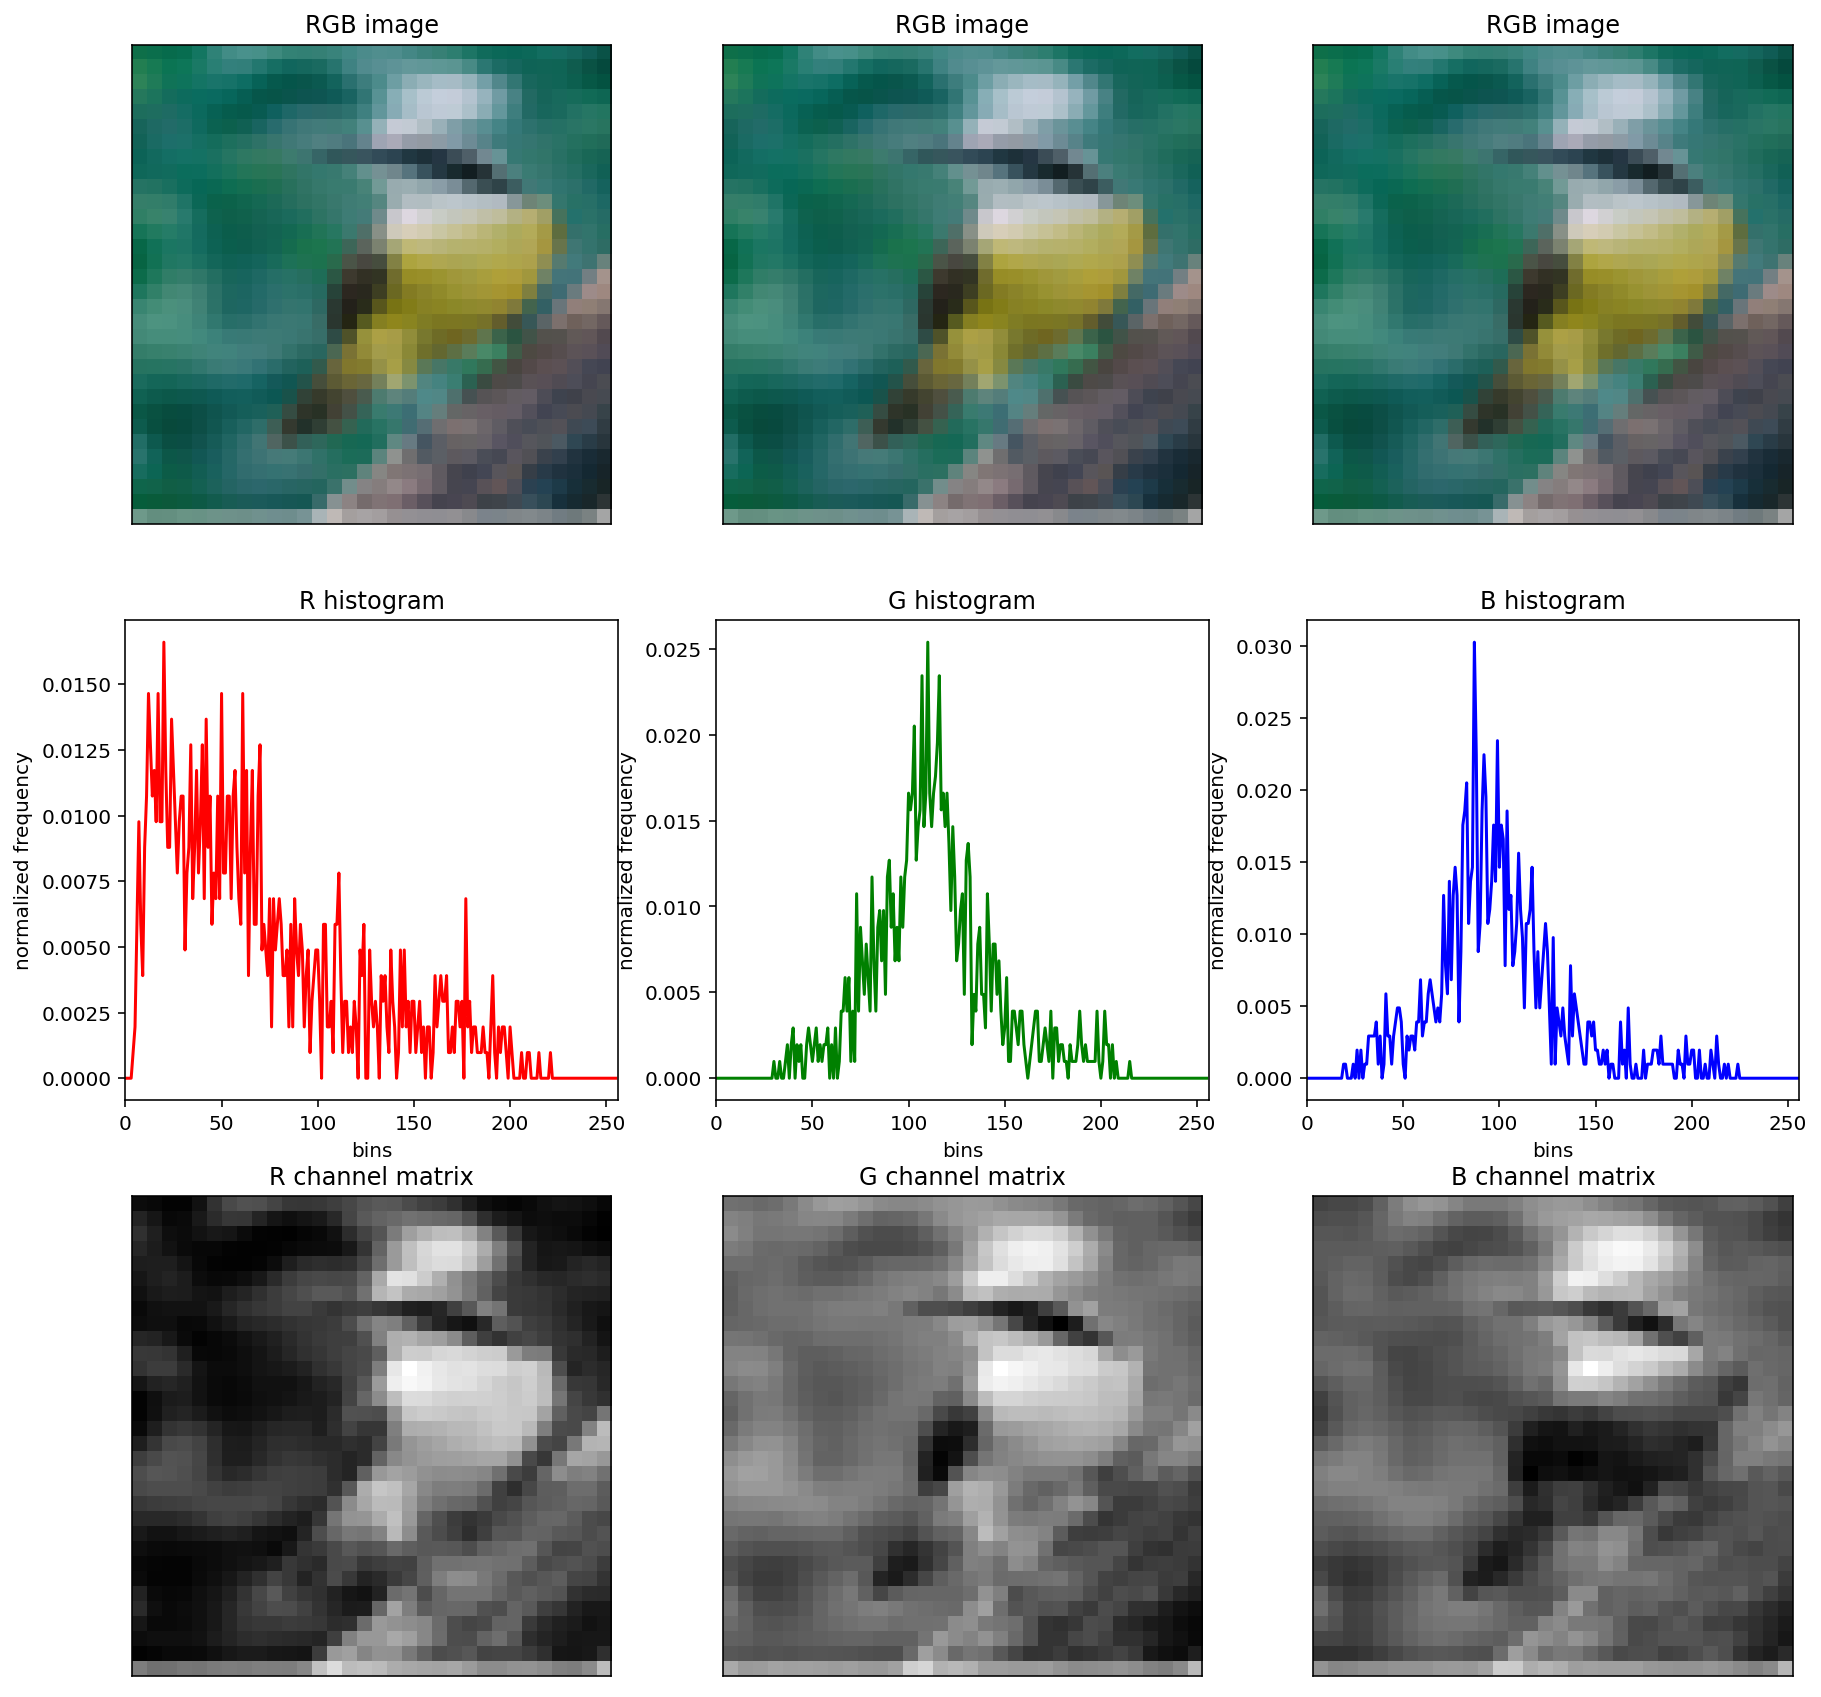

In [41]:
r_hist, g_hist, b_hist = calculate_color_histogram(index=27001)
plot_rgb(r_hist, g_hist, b_hist, index=27001)

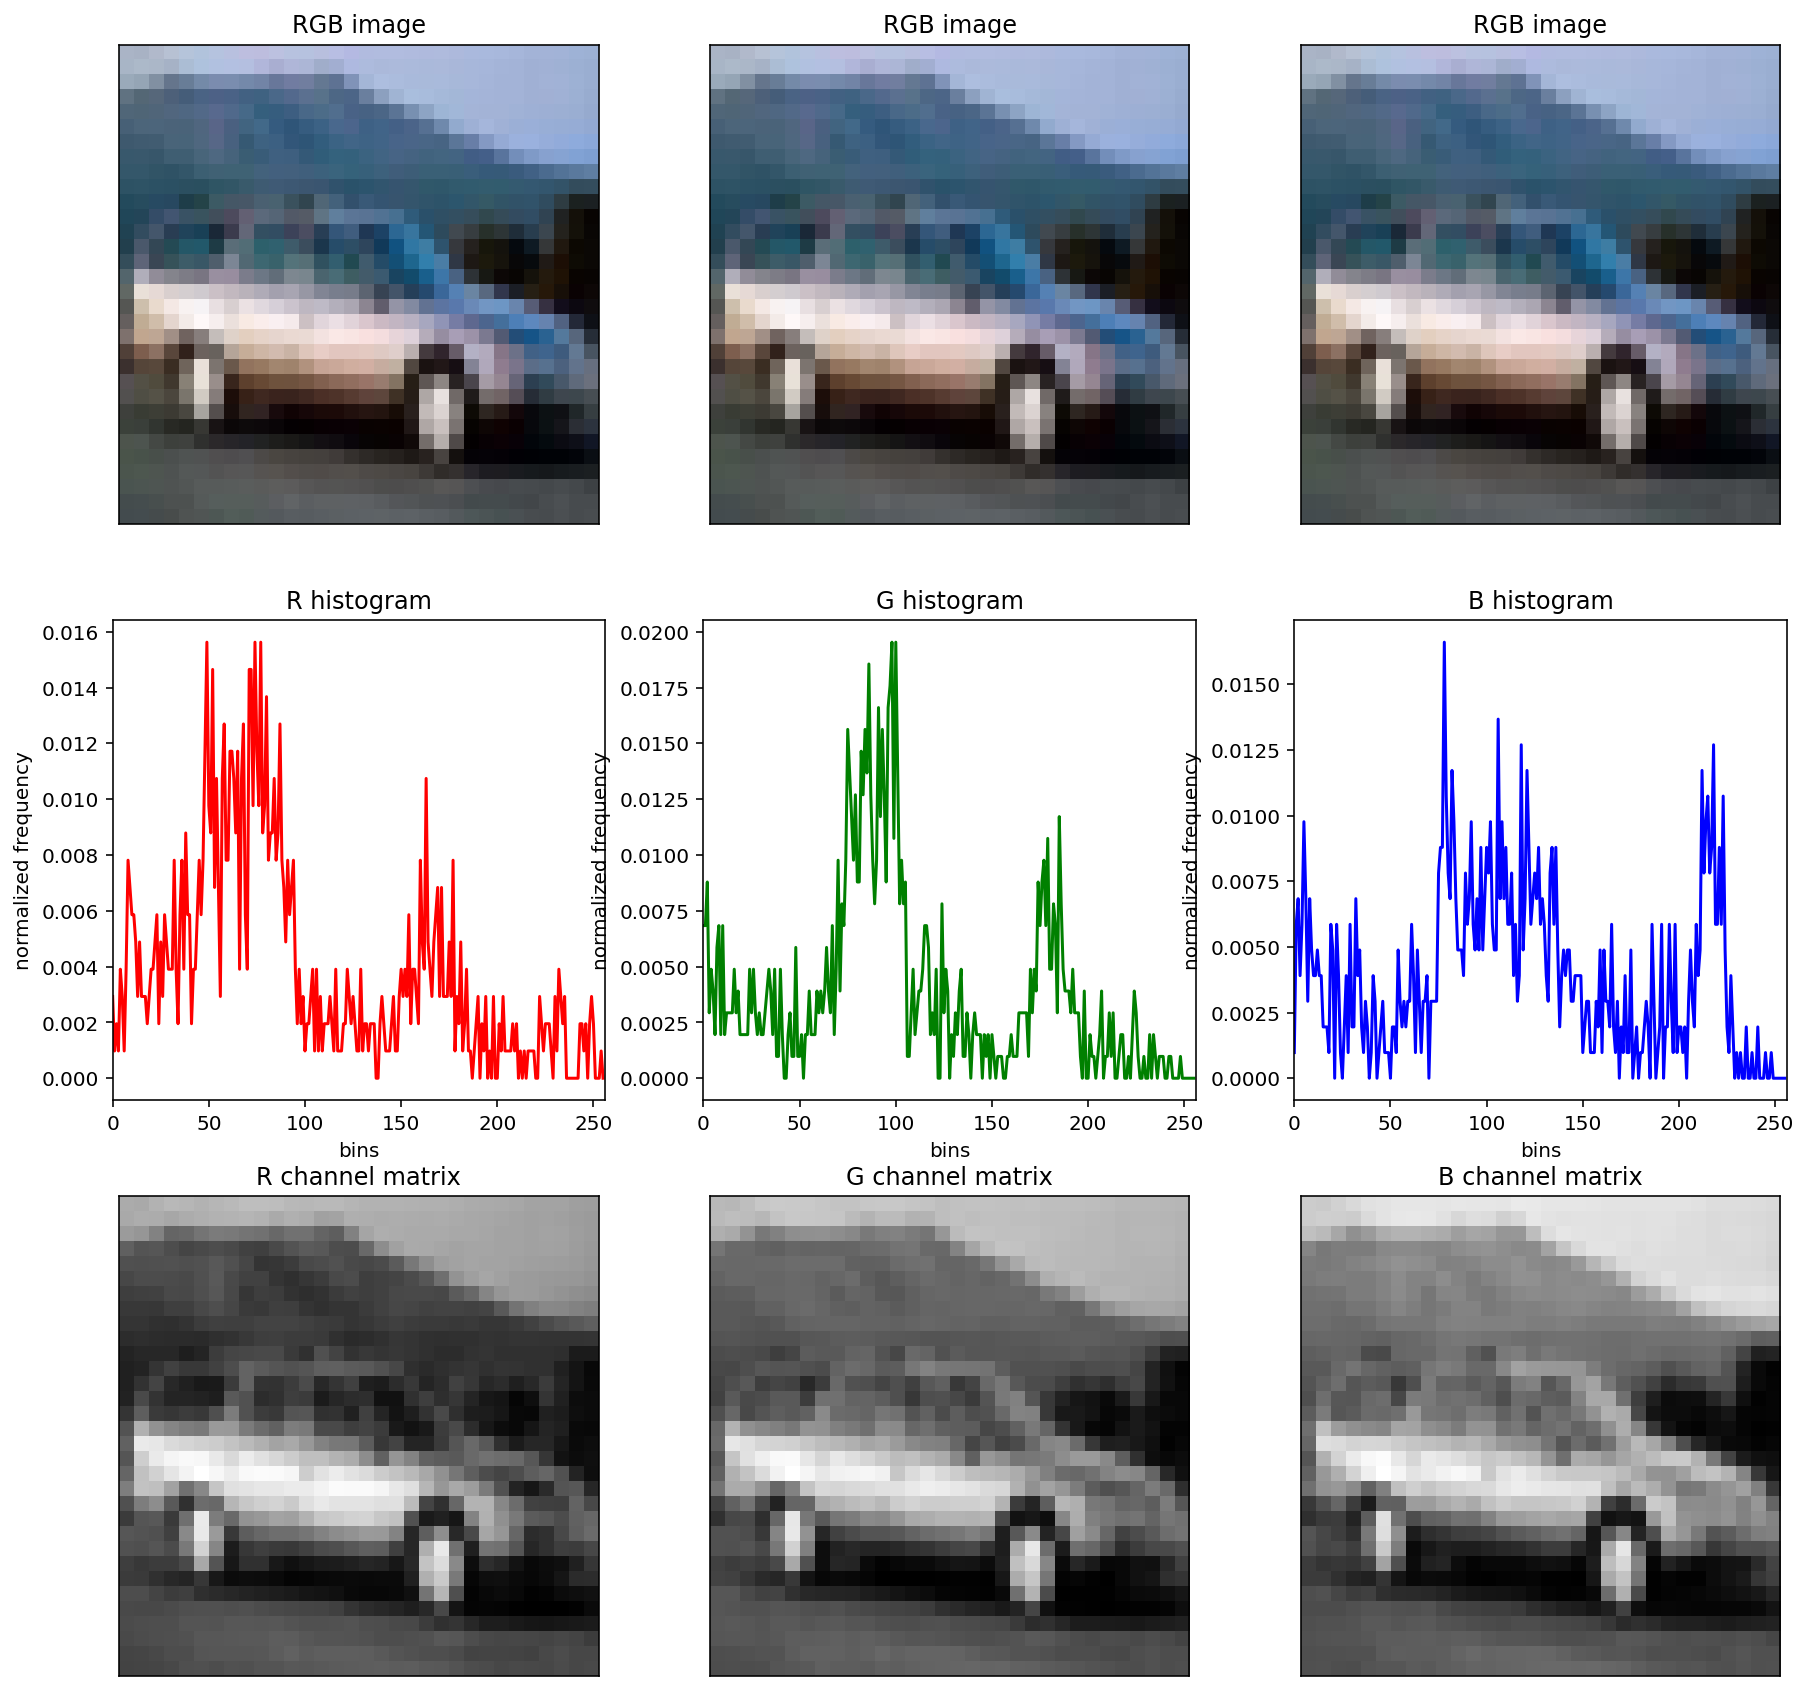

In [42]:
r_hist, g_hist, b_hist = calculate_color_histogram(index=4)
plot_rgb(r_hist, g_hist, b_hist, index=4)

### k-NN classifier 
features: 1. concatenation of R, G, B colour histograms

In [54]:
import time

start_time = time.time()
num_samples = X_train.shape[0]
X_train_feature_vects = np.zeros([num_samples, 3*256])
for i in range(0, num_samples): 
    r_hist, g_hist, b_hist = calculate_color_histogram(index=i)
    X_train_feature_vects[i, :] = np.concatenate((r_hist, g_hist, b_hist))
print("Time needed for feature extraction on the whole training dataset:", time.time() - start_time)


Time needed for feature extraction on the whole dataset: 15.800130367279053


In [56]:
start_time = time.time()
num_samples = X_test.shape[0]
X_test_feature_vects = np.zeros([num_samples, 3*256])
for i in range(0, num_samples): 
    r_hist, g_hist, b_hist = calculate_color_histogram(index=i)
    X_test_feature_vects[i, :] = np.concatenate((r_hist, g_hist, b_hist))
print("Time needed for feature extraction on the whole testing dataset:", time.time() - start_time)

Time needed for feature extraction on the whole testing dataset: 3.0456271171569824


In [60]:

def knn_evaluate(model):
    y_train_pred = model.predict(X_train_feature_vects)
    y_test_pred = model.predict(X_test_feature_vects)

    # accuracy
    print("#"*40)
    print("Accuracy on train: ", accuracy_score(y_true=y_train, y_pred=y_train_pred))
    print("Accuracy on test: ", accuracy_score(y_true=y_test, y_pred=y_test_pred))
    # recall
    print("#"*40)
    print("Recall on train: ", recall_score(y_true=y_train, y_pred=y_train_pred, average='macro'))
    print("Recall on test: ", recall_score(y_true=y_test, y_pred=y_test_pred, average = 'macro'))
    # precision
    print("#"*40)
    print("Precision on train: ", precision_score(y_true=y_train, y_pred=y_train_pred, average='macro'))
    print("Precision on test: ", precision_score(y_true=y_test, y_pred=y_test_pred, average='macro'))

    # plot confusion matrices
    print("#"*40)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    c_1 = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
    cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cmd_1.plot(ax=ax[0], cmap=plt.cm.Blues)
    ax[0].set_title("Confusion matrix: train data")

    c_2 = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cmd_2.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title("Confusion matrix: test data")

    k = model.n_neighbors
    plt.tight_layout()
    plt.suptitle("k-NN classifier, k = " + str(k), fontsize=15, ha='center')
    plt.subplots_adjust(top=0.85)

    plt.show()

########################################
Accuracy on train:  0.56236
Accuracy on test:  0.1038
########################################
Recall on train:  0.56236
Recall on test:  0.10380000000000003
########################################
Precision on train:  0.6088842413284654
Precision on test:  0.10401236686940611
########################################


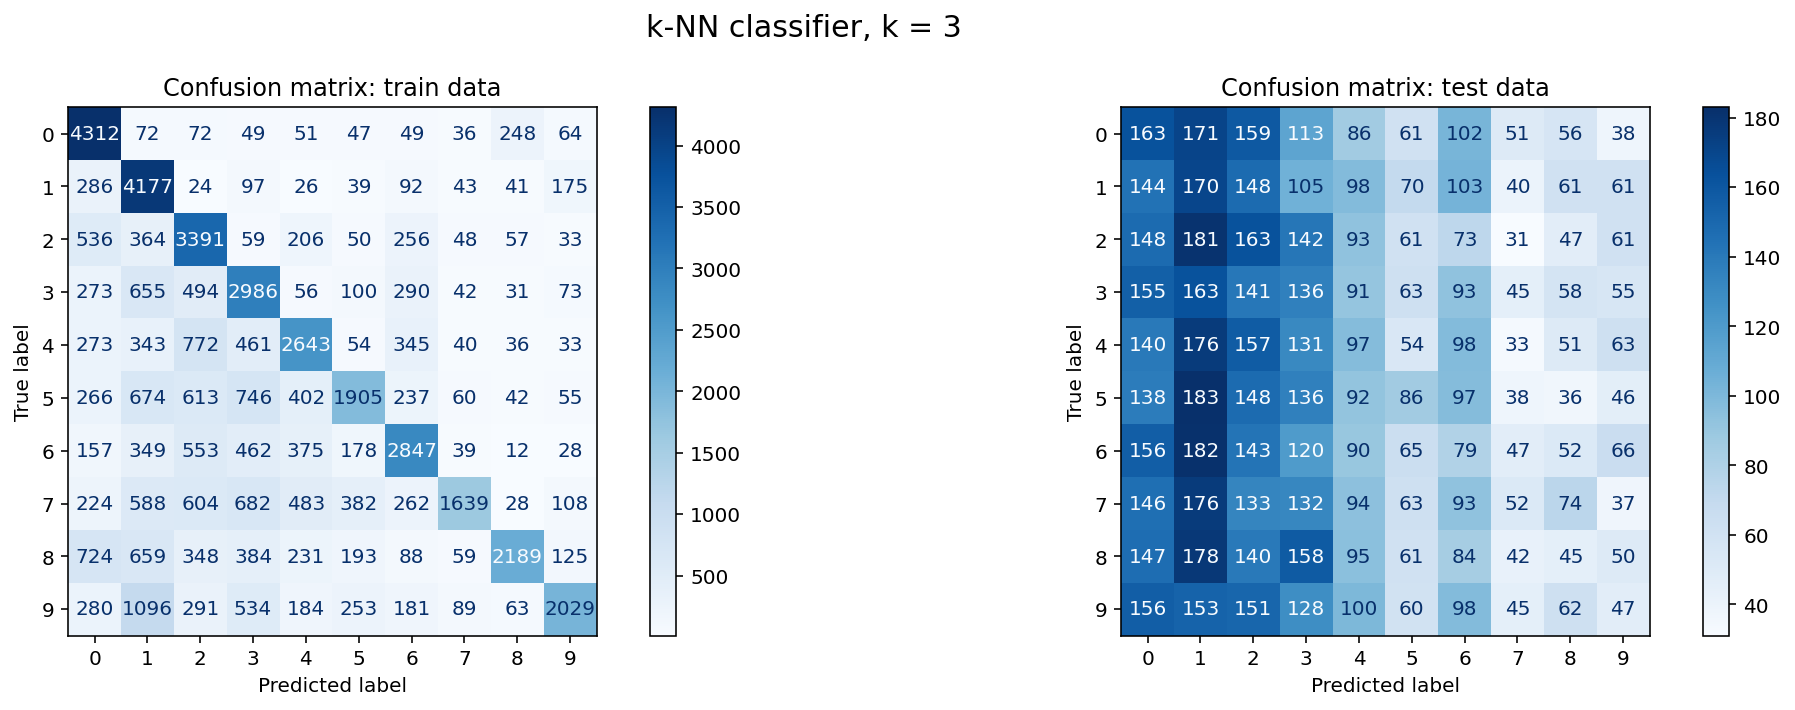

In [61]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_feature_vects, y_train)
knn_evaluate(knn)

########################################
Accuracy on train:  0.50016
Accuracy on test:  0.1023
########################################
Recall on train:  0.5001599999999999
Recall on test:  0.10229999999999999
########################################
Precision on train:  0.517988741213767
Precision on test:  0.10351629424394297
########################################


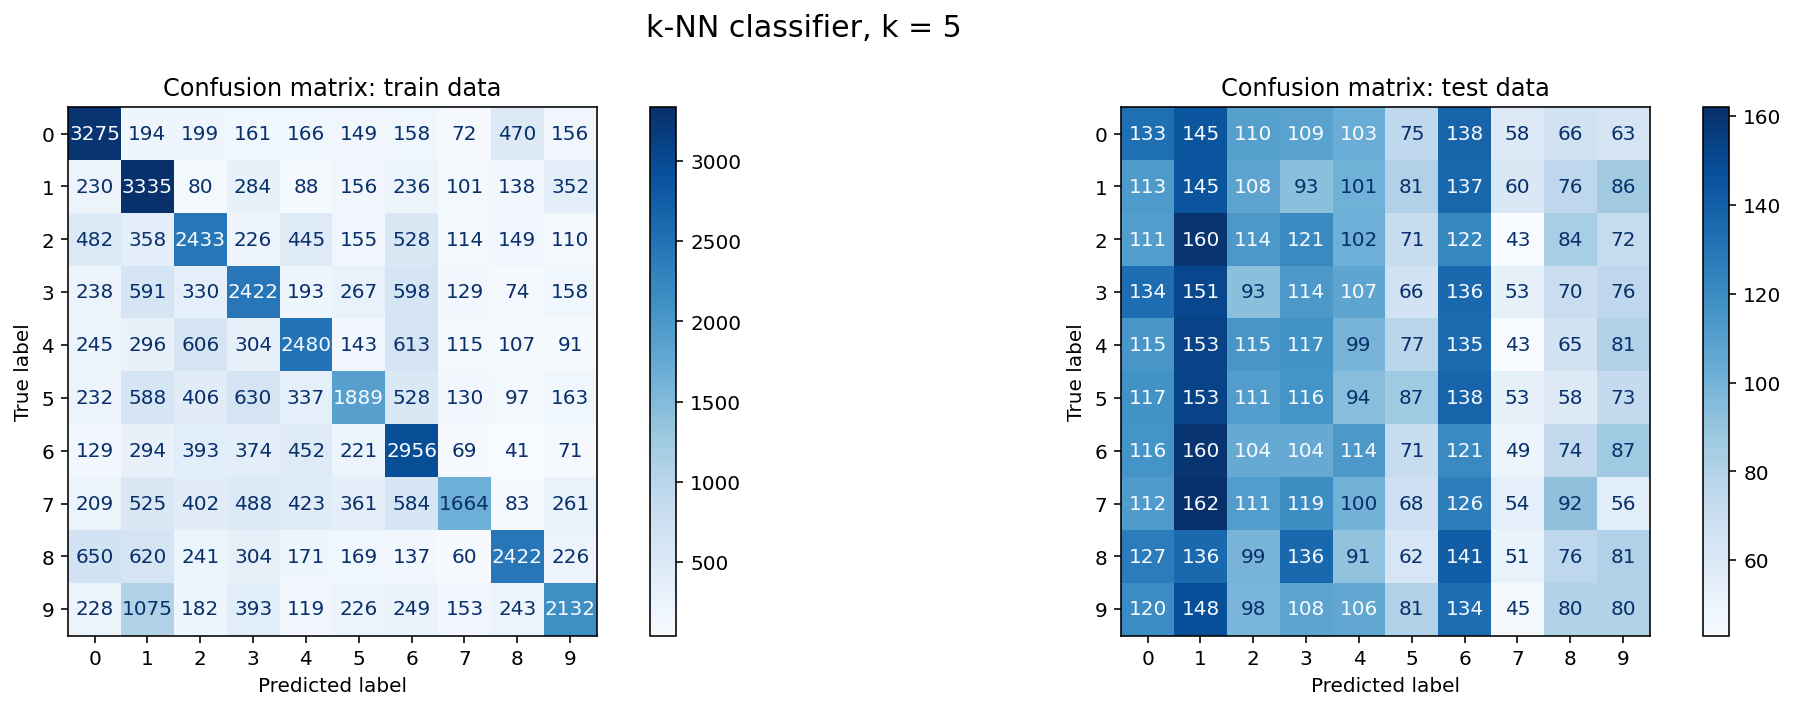

In [63]:
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_feature_vects, y_train)
knn_evaluate(knn)

Too simple features, proper classification and high accuracy score weren't even expected. We are going to try with more complex features...

### "Traditional" feature extraction methods: 2. Scale Invariant Feature Transform - SIFT

https://github.com/deepanshut041/feature-detection/blob/master/sift/sift.ipynb


SIFT is an algorithm that identifies keypoints and computes their corresponding descriptors. Keypoints represent points of interest in an image, and descriptors capture the local features by extracting small, fixed-size (128) patches (converted into vectors) around each keypoint, describing the surrounding area.

In [30]:
def sift(index):
    
    plt.imshow(X_train[index])
    plt.title("Initial image")
    plt.show()
    training_image  = X_train[index]
    
    #  converting image to RGB
    training_image = cv2.cvtColor(training_image, cv2.COLOR_BGR2RGB)
    # converting to gray scale
    training_image_gray = cv2.cvtColor(training_image,cv2.COLOR_RGB2GRAY)

    # detecting keypoints
    sift = cv2.SIFT_create()
    train_keypoints, train_descriptor = sift.detectAndCompute(training_image_gray, None)
    keypoints_without_size = np.copy(training_image)
    keypoints_with_size = np.copy(training_image)

    cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))
    cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Display image with and without keypoints size
    fx, plots = plt.subplots(1, 2, figsize=(5,5))

    plots[0].set_title("Train keypoints With Size")
    plots[0].imshow(keypoints_with_size, cmap='gray')

    plots[1].set_title("Train keypoints Without Size")
    plots[1].imshow(keypoints_without_size, cmap='gray')

    # Print the number of keypoints detected in the training image
    print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))
    # print(train_keypoints)
    # print(train_descriptor)
    # print(train_descriptor.shape)



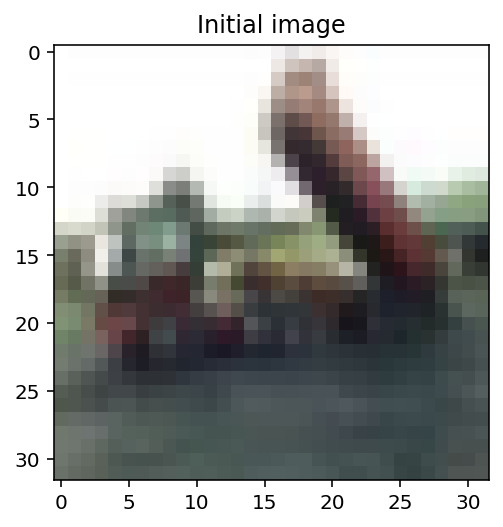

Number of Keypoints Detected In The Training Image:  13


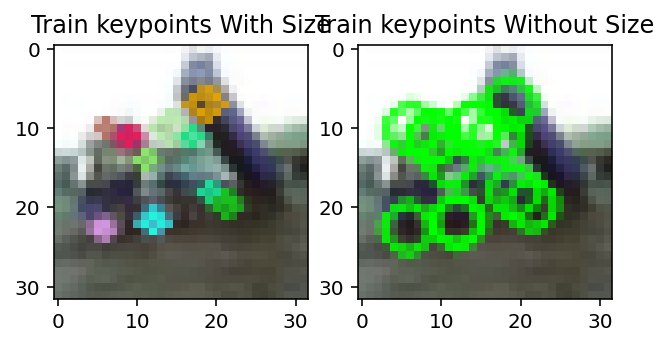

In [18]:
sift(2)

## COULD BE HELPFUL FOR BAG OF WORDS & BASELINE

https://github.com/shubpate/bag_of_visual_words/blob/master/bag_of_SIFT_features_KNN_SVM_training.py


In [423]:
# def formatND(l):
#         print ("Stacking begins ..")
#         vStack = np.array(l[0])
#         for remaining in l[1:]:
#             vStack = np.vstack((vStack, remaining))
#         print ("Stacking done")
#         return vStack

In [426]:
# def create_des_list(X):
#     sift = cv2.SIFT()
#     des_list = []
#     for image in X:
#         kp, des = sift.detectAndCompute(image,None)
#         des_list.append(des)
#     return np.array(des_list)

####  THIS LINK SEEMS TO DO WHAT WE ARE TRYING TO ACHIEVE I BELIEVE
https://github.com/shubpate/bag_of_visual_words/blob/master/bag_of_SIFT_features_KNN_SVM_training.py

In [ ]:
def create_descriptor_list(subset):
    X_train_subset = X_train[:subset]
    sift = cv2.SIFT()
    list_of_all_descriptors = []

    for i in range(0, subset):
        img = X_train_subset[i]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # converting image to RGB (not necessary since it's already in RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # converting to gray scale

        # detecting keypoints
        sift = cv2.SIFT_create()
        train_keypoints, train_descriptor = sift.detectAndCompute(img, None)

        list_of_all_descriptors.append(train_descriptor)  

    return list_of_all_descriptors

In [435]:
def develop_vocabulary_try(n_images, descriptor_list, no_clusters, kmeans_ret):
 
    mega_histogram = np.array([np.zeros(no_clusters) for _ in range(n_images)])  # #n_images x #no_clusters
    old_count = 0
    for i in range(n_images):
        l = len(descriptor_list[i])
        for j in range(l):
            idx = kmeans_ret[old_count+j]
            mega_histogram[i][idx] += 1
        old_count += l
    print ("Vocabulary Histogram Generated")

    return mega_histogram

In [31]:
def format_vocab(l):
    # 

    print ("Stacking begins ..")
    vStack = np.array(l[0])
    for remaining in l[1:]:
        vStack = np.vstack((vStack, remaining))
    print ("Stacking done")

    return vStack

In [431]:
no_clusters = 10
list_of_all_descriptors = create_descriptor_list(subset=4)
des_stack = format_vocab(list_of_all_descriptors) 

start_time = time.time()
print("Starting with clustering...")
kmeans_obj = KMeans( no_clusters)
kmeans_ret = kmeans_obj.fit_predict(des_stack)
print("Clustering completed!")
print("Time taken : ",time.time() - start_time )

Stacking begins ..
Stacking done
Starting with clustering...
Clustering completed!
Time taken :  0.06025505065917969


/Users/nadia/Desktop/TUSS23/ML/MachineLearningEx3/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [438]:
mega_histogram = develop_vocabulary_try(4, list_of_all_descriptors,10,kmeans_ret)

Vocabulary Histogram Generated


### TRYING... AND TRYING... 

In [14]:
from sklearn.cluster import KMeans
import time

def generate_vocabulary(n_images, no_clusters):

    # list_of_all_descriptors: list of numpy arrays such that each element of the list - 2D numpy array 
    # corresponds to descriptors of the one training image
    # descriptor matrix of one image: (#keypoints x 128)

    print("SIFT feature extraction begins...")
    start_time = time.time()
    X_train_subset = X_train[:n_images]
    sift = cv2.SIFT()
    list_of_all_descriptors = []

    for i in range(0, n_images):
        img = X_train_subset[i]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # converting image to RGB (not necessary since it's already in RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # converting to gray scale

        # detecting keypoints
        sift = cv2.SIFT_create()
        train_keypoints, train_descriptor = sift.detectAndCompute(img, None)
        list_of_all_descriptors.append(train_descriptor)  

    print("Time taken for SIFT feature extraction:", time.time() - start_time)

    # converting into 2D numpy array (vertical stacking of the list elements): mat_of_all_descriptors

    print ("Stacking begins...")
    mat_of_all_descriptors = np.array(list_of_all_descriptors[0])
    for remaining in list_of_all_descriptors[1:]:
        if remaining is not None:                   # THINK ABOUT THIS PART A BIT MORE!!!!!!!!!!!!!!!!!!
            # IT HAS HAPPENED THAT SIFT DETECTOR DOESN'T DETECT ANY KEYPOINTS -> EXCLUDE EMPTY LISTS
            # IMAGE NUMBER 906 IS PROBLEMATIC FOR E.G
            # I THINK THAT EVERYTHING IS OK NOW (WITH SMALL EDGE CASE IN histogram_creation)
            mat_of_all_descriptors = np.vstack((mat_of_all_descriptors, remaining))
    print ("Stacking done")

    # perform clustering: K-means algorithm

    start_time = time.time()
    print("Starting with clustering...")
    kmeans_obj = KMeans(no_clusters)
    kmeans_ret = kmeans_obj.fit_predict(mat_of_all_descriptors) # fitting the model: class label assigned to each descriptor
    # centroids = kmeans_obj.cluster_centers_
    print("Clustering completed!")
    print("Time taken for clustering:", time.time() - start_time)

    return list_of_all_descriptors, kmeans_obj

In [15]:
list_of_all_descriptors, kmeans_obj = generate_vocabulary(n_images=100, no_clusters=15)

SIFT feature extraction begins...
Time taken for SIFT feature extraction: 0.10856103897094727
Stacking begins...
Stacking done
Starting with clustering...


/Users/nadia/Desktop/TUSS23/ML/MachineLearningEx3/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nadia/Desktop/TUSS23/ML/MachineLearningEx3/venv/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


Clustering completed!
Time taken for clustering: 0.30754613876342773


In [16]:
def histogram_creation(descriptor_list, kmeans_obj):

    n_images = len(descriptor_list)
    kmeans_ret = kmeans_obj.labels_
    no_clusters = len(kmeans_obj.cluster_centers_)

 
    mega_histogram = np.array([np.zeros(no_clusters) for _ in range(n_images)])  # #n_images x #no_clusters
    old_count = 0
    for i in range(n_images):
        if descriptor_list[i] is None:
            continue 
        l = len(descriptor_list[i])
        for j in range(l):
            idx = kmeans_ret[old_count+j]
            mega_histogram[i][idx] += 1
        old_count += l
    print ("Vocabulary Histogram Generated")

    return mega_histogram

In [17]:
mega_histogram = histogram_creation(descriptor_list=list_of_all_descriptors, kmeans_obj=kmeans_obj)

Vocabulary Histogram Generated


In [19]:
mega_histogram.shape

(1000, 15)

### Histogram: results inspection

In [20]:
n_images = 1000
no_clusters = 15
list_of_all_descriptors, kmeans_obj = generate_vocabulary(n_images=n_images, no_clusters=no_clusters)
mega_histogram = histogram_creation(descriptor_list=list_of_all_descriptors, kmeans_obj=kmeans_obj)

SIFT feature extraction begins...
Time taken for SIFT feature extraction: 0.9968218803405762
Stacking begins...
Stacking done
Starting with clustering...


c:\Users\sofij\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Clustering completed!
Time taken for clustering: 2.015587568283081
Vocabulary Histogram Generated


In [21]:
def plot_bowv_histogram(axis, img_idx):
    class_label = y_train[img_idx]
    x_labels = np.arange(0, no_clusters)
    data = mega_histogram[img_idx, :]

    axis.bar(x_labels, data)
    axis.set_xlabel("visual word index")
    axis.set_ylabel("frequency")
    axis.set_title(f"Histogram of image: {img_idx}, class label: {class_label}")

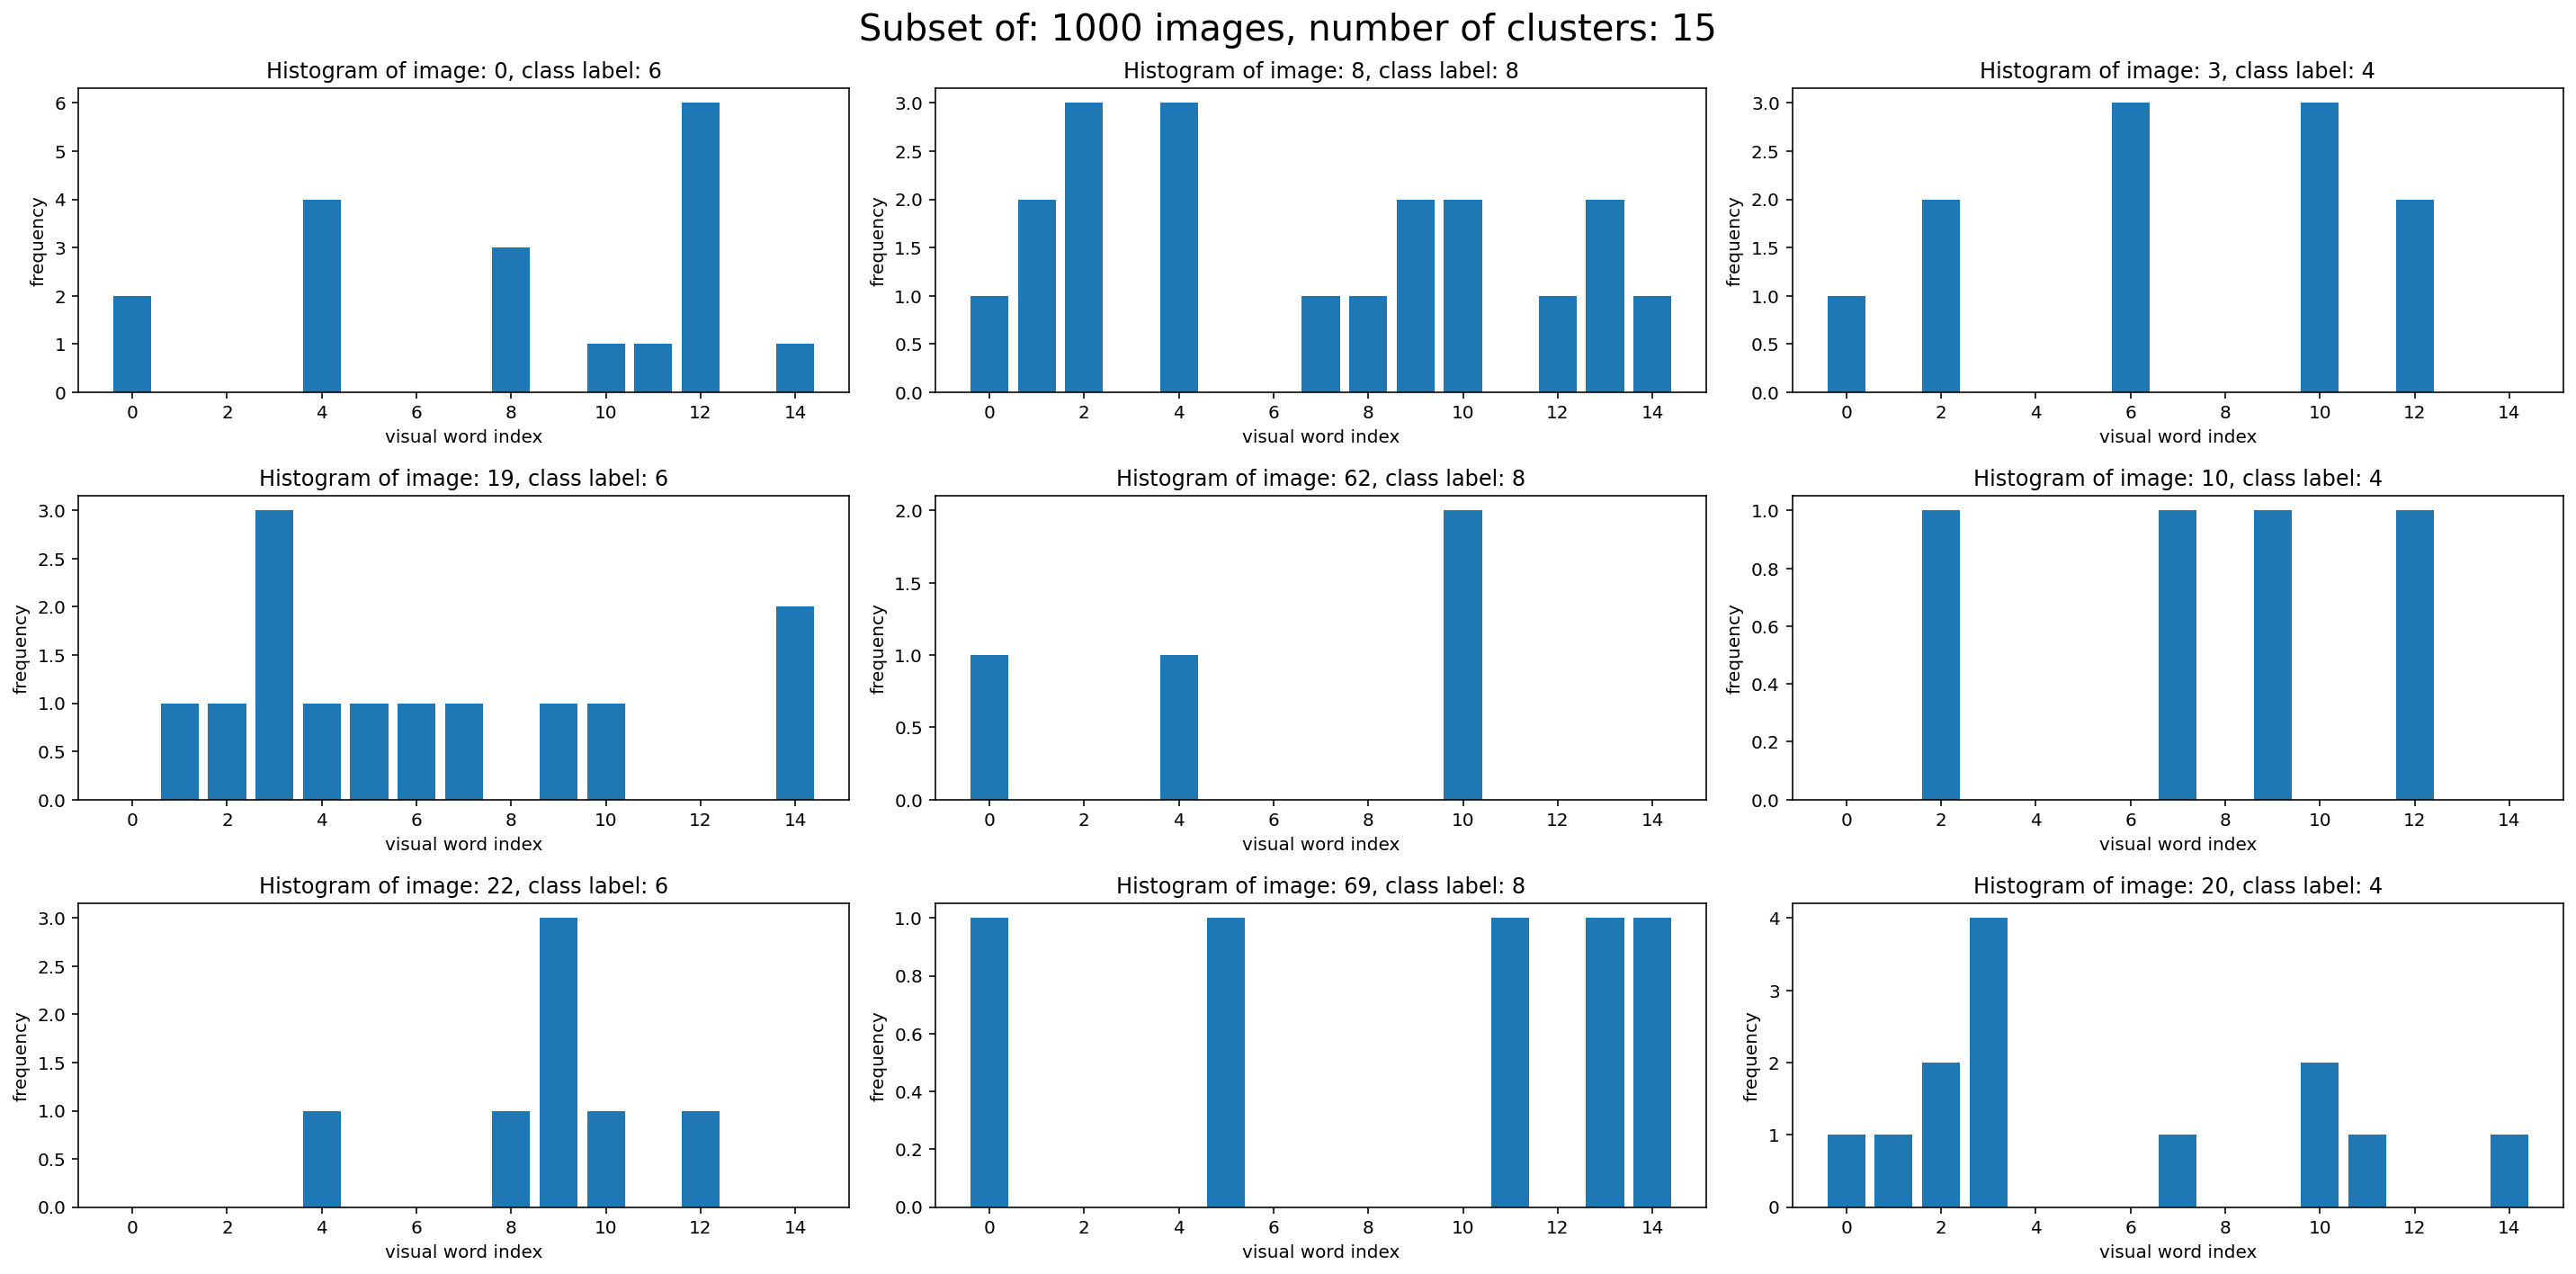

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))

indices_6 = np.where(y_train == 6)[0][:3]  # first 3 images belonging to class 6
for i, img_idx in enumerate(indices_6):
    plot_bowv_histogram(ax[i, 0], img_idx)

indices_8 = np.where(y_train == 8)[0][:3]  # first 3 images belonging to class 8
for i, img_idx in enumerate(indices_8):
    plot_bowv_histogram(ax[i, 1], img_idx)

indices_4 = np.where(y_train == 4)[0][:3]  # first 3 images belonging to class 4
for i, img_idx in enumerate(indices_4):
    plot_bowv_histogram(ax[i, 2], img_idx)

plt.suptitle(f"Subset of: {n_images} images, number of clusters: {no_clusters}", fontsize=20)

plt.tight_layout()
plt.show()


In [24]:
n_images = len(X_test) # whole dataset
no_clusters = 15
list_of_all_descriptors, kmeans_obj = generate_vocabulary(n_images=n_images, no_clusters=no_clusters)
mega_histogram = histogram_creation(descriptor_list=list_of_all_descriptors, kmeans_obj=kmeans_obj)

SIFT feature extraction begins...
Time taken for SIFT feature extraction: 8.619746446609497
Stacking begins...
Stacking done
Starting with clustering...


c:\Users\sofij\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Clustering completed!
Time taken for clustering: 18.78606867790222
Vocabulary Histogram Generated


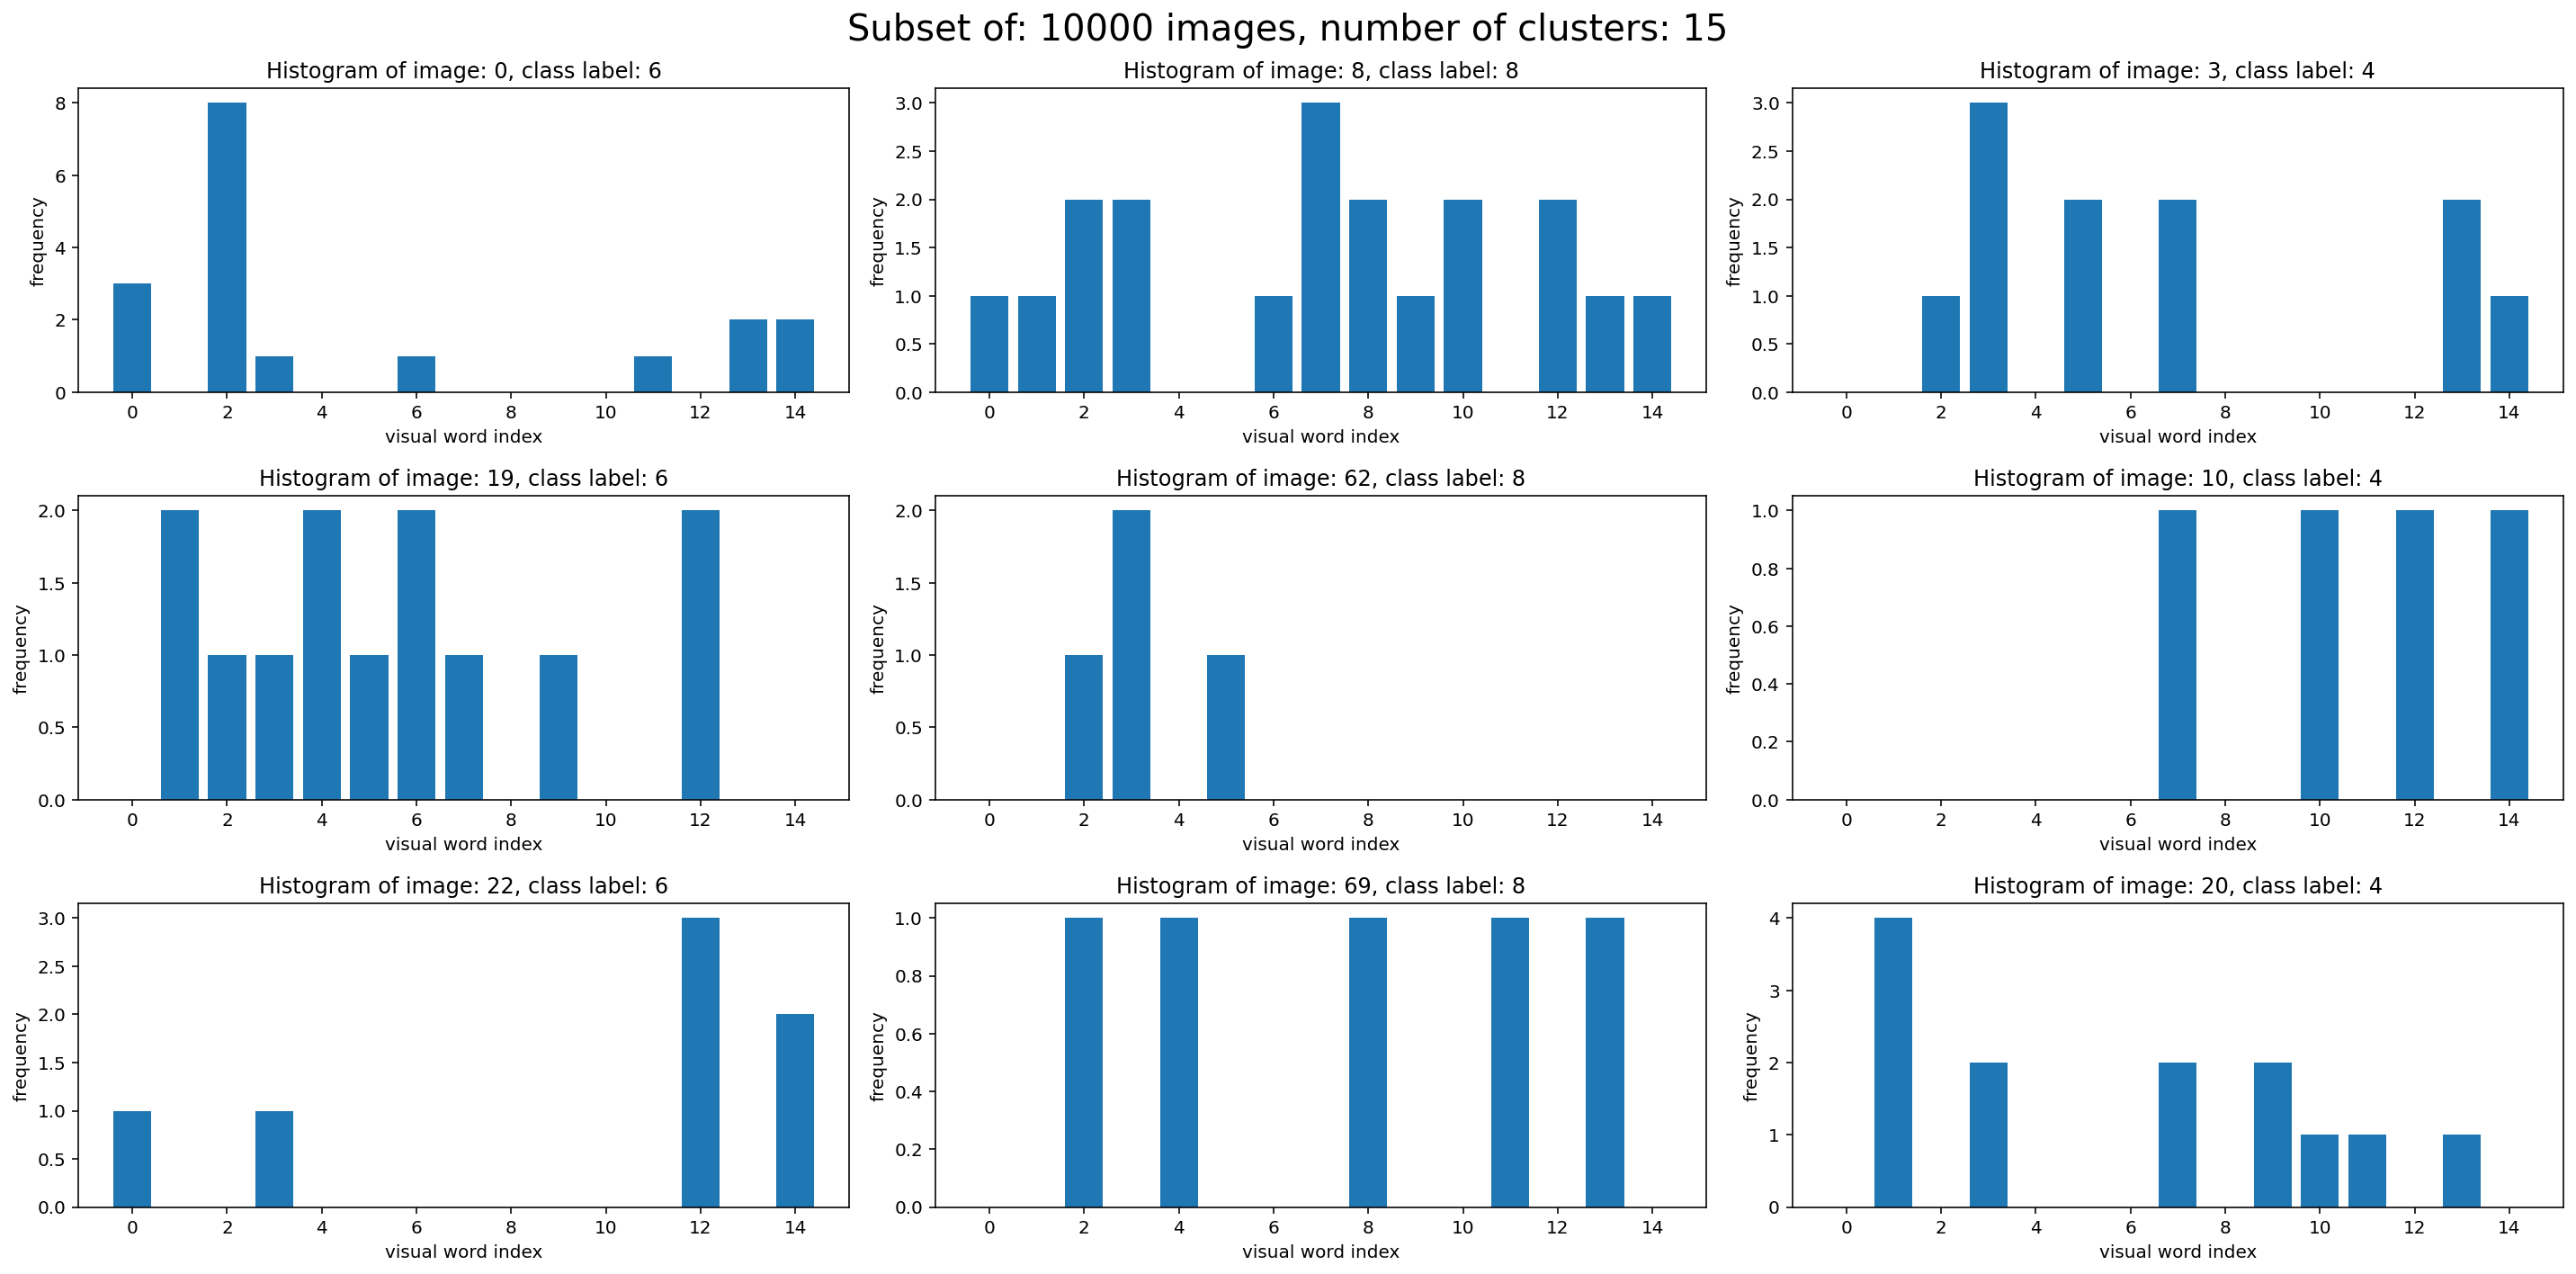

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))

indices_6 = np.where(y_train == 6)[0][:3]  # first 3 images belonging to class 6
for i, img_idx in enumerate(indices_6):
    plot_bowv_histogram(ax[i, 0], img_idx)

indices_8 = np.where(y_train == 8)[0][:3]  # first 3 images belonging to class 8
for i, img_idx in enumerate(indices_8):
    plot_bowv_histogram(ax[i, 1], img_idx)

indices_4 = np.where(y_train == 4)[0][:3]  # first 3 images belonging to class 4
for i, img_idx in enumerate(indices_4):
    plot_bowv_histogram(ax[i, 2], img_idx)

plt.suptitle(f"Subset of: {n_images} images, number of clusters: {no_clusters}", fontsize=20)

plt.tight_layout()
plt.show()


### HISTOGRAMS OF SAME CLASSES LOOK COMPLETELY DIFFERENT :(((
15 CLUSTERS WAS DEFINITELY NOT A GOOD IDEA lool (but ok for plotting)

In [254]:
n_images = len(X_test) # whole dataset
no_clusters = 100
list_of_all_descriptors, kmeans_obj = generate_vocabulary(n_images=n_images, no_clusters=no_clusters)
mega_histogram = histogram_creation(descriptor_list=list_of_all_descriptors, kmeans_obj=kmeans_obj)

Stacking begins ..
Stacking done
Starting with clustering...


c:\Users\sofij\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Clustering completed!
Time taken for clustering: 136.73791527748108
Vocabulary Histogram Generated


In [255]:
indices_6 = np.where(y_train == 6)[0][:3]  # first 3 images belonging to class 6
for i in range(0, 3):
    print(mega_histogram[indices_6[i]])
print('__________________________________________________')
indices_8 = np.where(y_train == 8)[0][:3]  # first 3 images belonging to class 8
for i in range(0, 3):
    print(mega_histogram[indices_8[i]])
print('__________________________________________________')
indices_4 = np.where(y_train == 4)[0][:3]  # first 3 images belonging to class 4
for i in range(0, 3):
    print(mega_histogram[indices_4[i]])
print('__________________________________________________')

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 2. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 2. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0.]
__________________________________________________
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

### KNN Train and Test

In [118]:
list_of_all_descriptors, kmeans_obj = generate_vocabulary(n_images=50000, no_clusters=10)
mega_histogram = histogram_creation(descriptor_list=list_of_all_descriptors, kmeans_obj=kmeans_obj)

SIFT feature extraction begins...
Time taken for SIFT feature extraction: 51.33370113372803
Stacking begins...
Stacking done
Starting with clustering...
Clustering completed!
Time taken for clustering: 180.7230088710785
Vocabulary Histogram Generated


In [141]:
with open('mega_histogram_train.txt', 'wb') as f:
    np.save(f, mega_histogram)

In [142]:
with open('mega_histogram_train.txt', 'rb') as f:
    a = np.load(f)

In [119]:
def train_knn(X,y):
    start_time = time.time()
    print("Starting with training of KNN model...")
    knn_model = KNeighborsClassifier(len(np.unique(y)))
    knn_model.fit(X, y)
    print("Training completed!")
    print ("Time taken in training {0}".format((time.time() - start_time)))
    return knn_model

In [143]:
def recognize(model, test_img):
    sift = cv2.SIFT_create()
    img_keypoints, img_desc = sift.detectAndCompute(test_img, None)
    vocab = np.array( [[ 0 for i in range(no_clusters)]])
    if img_desc is not None:
        test_ret = kmeans_obj.predict(img_desc)
        for each in test_ret:
            vocab[0][each] +=1
        lb = model.predict(vocab)
        return lb
    else:
        lb = np.array([-1000])
        return lb

def test_model(model,x_test):
    predictions = []
    start_time = time.time()
    print ("Testing started ..")
    for image in x_test:
        cl = recognize(model,image)
        predictions.append(cl)
    print ("Testing completed")
    print ("Time taken in testing - {0}".format((time.time() - start_time)))
    return np.array(predictions)

In [69]:
predictions_knn = test_model(train_knn(mega_histogram,y_test[:2000]),X_test[:2000])

Starting with training of KNN model...
Training completed!
Time taken in training 0.0037729740142822266
Testing started ..
Testing completed
Time taken in testing - 5.49481201171875


In [70]:
predictions_knn = np.reshape(predictions_knn,(1,-1))
accuracy = np.sum(np.array(predictions_knn) == y_test[:2000]) / len(X_test[:2000])
print ("The accuracy of KNN model is {:.2f}%".format(accuracy*100))


The accuracy of KNN model is 9.45%


In [121]:
y_test_pred = test_model(train_knn(mega_histogram,y_test),X_test)

Starting with training of KNN model...


ValueError: Found input variables with inconsistent numbers of samples: [50000, 10000]

In [122]:
y_train_pred = test_model(train_knn(mega_histogram,y_train),X_train)

Starting with training of KNN model...
Training completed!
Time taken in training 0.058244943618774414
Testing started ..


KeyboardInterrupt: 

In [116]:
def evaluate_model(y_train_pred,y_test_pred):
    # accuracy
    print("#"*40)
    print("Accuracy on train: ", accuracy_score(y_true=y_train, y_pred=y_train_pred))
    print("Accuracy on test: ", accuracy_score(y_true=y_test, y_pred=y_test_pred))
    # recall
    print("#"*40)
    print("Recall on train: ", recall_score(y_true=y_train, y_pred=y_train_pred, average='macro'))
    print("Recall on test: ", recall_score(y_true=y_test, y_pred=y_test_pred, average = 'macro'))
    # precision
    print("#"*40)
    print("Precision on train: ", precision_score(y_true=y_train, y_pred=y_train_pred, average='macro'))
    print("Precision on test: ", precision_score(y_true=y_test, y_pred=y_test_pred, average='macro'))

    # plot confusion matrices
    print("#"*40)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    c_1 = confusion_matrix(y_true=y_train[:2000], y_pred=y_train_pred)
    cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','10'])
    cmd_1.plot(ax=ax[0], cmap=plt.cm.Blues)
    ax[0].set_title("Confusion matrix: train data")

    c_2 = confusion_matrix(y_true=y_test[:2000], y_pred=y_test_pred)
    cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','10'])
    cmd_2.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title("Confusion matrix: test data")

    k = 10
    plt.tight_layout()
    plt.suptitle("k-NN classifier, k = " + str(k), fontsize=15, ha='center')
    plt.subplots_adjust(top=0.85)

    plt.show()

In [117]:
evaluate_model(y_train_pred,y_test_pred)

########################################


ValueError: Found input variables with inconsistent numbers of samples: [50000, 2000]

In [ ]:
### Needs to be modified 

# hmmmm as far as i understand, step is used for undersampling the input image. maybe it should be useful in our 2nd dataset 
# (if we have bigger images). but i'm a bit afraid if it would work since that's not the way how we generated clusters during
# vocabulary formation at first :(( ooofc we can try and leave step=1 as default


### WHEN USING THIS KERNEL CRASHES , I USED THE FUNCTION ABOVE , I HOPE IT IS CORRECT :(


# def recognize(model, test_img, step):
#     sift = cv2.SIFT()
#     #kp, des = sift.detectAndCompute(test_img,None)
#     cols, rows,ch = test_img.shape
#     kps = []
#     for x in range(step, rows, step):
#         for y in range(step, cols, step):
#             kps.append(cv2.KeyPoint(x,y,step))
#     kps, des = sift.compute(test_img,kps)
#     vocab = np.array( [[ 0 for i in range(no_clusters)]])
#     test_ret = kmeans_obj.predict(des)
#     for each in test_ret:
#         vocab[0][each] += 1
#     lb =  model.predict(vocab)
#     return lb

# def test_model(model, x_test):
#     predictions=[]
#     start_time = time.time()
#     print ("Testing started ..")
#     for image in x_test:
#         cl= recognize(model, image, 15)
#         predictions.append(cl)
#     print ("Testing completed")
#     print ("Time taken in testing - {0}".format((time.time() - start_time)))
#     return np.array(predictions)



In [38]:
no_clusters = 10

Starting with training of KNN model...
Training completed!
Time taken in training 0.002317667007446289
Testing started ..
[0]
[2]
[9]
[9]
[1]
[9]
[6]
[6]
[3]
[9]
[9]
[8]
[0]
[7]
[1]
[2]
[0]
[1]
[3]
[5]
[5]
[4]
[0]
[5]
[0]
[0]
[5]
[0]
[6]
[7]
[3]
[1]
[6]
[1]
[3]
[2]
[3]
[6]
[1]
[1]
[0]
[2]
[6]
[2]
[0]
[2]
[0]
[0]
[1]
[3]
[0]
[3]
[1]
[3]
[4]
[9]
[5]
[8]
[2]
[1]
[9]
[2]
[2]
[4]
[1]
[5]
[0]
[0]
[1]
[8]
[4]
[9]
[6]
[6]
[0]
[2]
[1]
[9]
[9]
[1]
[9]
[6]
[1]
[8]
[2]
[2]
[0]
[9]
[0]
[1]
[1]
[6]
[0]
[2]
[5]
[8]
[3]
[6]
[5]
[9]
[6]
[7]
[7]
[1]
[8]
[9]
[1]
[4]
[9]
[5]
[7]
[2]
[6]
[6]
[2]
[0]
[3]
[1]
[9]
[1]
[6]
[2]
[2]
[1]
[8]
[6]
[8]
[5]
[9]
[3]
[6]
[3]
[0]
[0]
[0]
[2]
[1]
[6]
[4]
[1]
[9]
[7]
[0]
[6]
[2]
[0]
[5]
[9]
[5]
[6]
[0]
[7]
[2]
[6]
[4]
[2]
[0]
[1]
[6]
[4]
[1]
[3]
[5]
[1]
[1]
[1]
[7]
[3]
[2]
[4]
[2]
[1]
[3]
[6]
[0]
[9]
[2]
[0]
[0]
[0]
[4]
[1]
[4]
[4]
[2]
[6]
[6]
[7]
[9]
[4]
[7]
[1]
[3]
[4]
[2]
[3]
[4]
[6]
[1]
[1]
[9]
[2]
[1]
[7]
[7]
[0]
[3]
[8]
[0]
[7]
[2]
[3]
[7]
[4]
[8]
[7]
[0]
[6]
[1]
[0

In [38]:
len(kps)

225

In [443]:
train_knn(mega_histogram,y_train[:4])

Starting with training of KNN model...
Training completed!
Time taken in training 0.010057926177978516


KNeighborsClassifier(n_neighbors=3)

### Bag of Visual Words Model for Image Classification
https://kushalvyas.github.io/BOV.html

1. keypoint detection and feature extraction 

Keypoints could be detected using SIFT algorithm. Once keypoints are identified, local features -  descriptors are extracted around each keypoint. These descriptors encode the information about the visual characteristics of the image region around the keypoint. Therefore each image from the training dataset is now represented as a set of descriptors. SIFT returns m x 128 dimension array (m - number of keypoints).


2. building a visual vocabulary

Firstly, we group all the descriptors (obtained from all the images from the training dataset) into predefined number of clusters (using K-means algorithm, reason: information compression and grouping similar features). The K centroids ("visual words") obtained from the clustering process together form the visual vocabulary. This vocabulary represents the distinctive local patterns found in the dataset.


3. assign visual words to image descriptors

For each image in the training dataset, the descriptors are again extracted, and each descriptor is assigned to the closest visual word (centroid) from the visual vocabulary. This assignment is done using distance metrics like Euclidean distance or cosine similarity.

4. histogram creation

The image is represented as a histogram, where each bin of the histogram corresponds to a visual word from the vocabulary. The value of each bin represents the frequency of occurrence of the corresponding visual word in the image. In other words, the histogram counts how many times each visual word appears in the image.

5. train a classifier

Once the images are represented as histograms of visual words, a classifier is trained on these histogram representations. The classifier learns to differentiate between different image categories based on the frequency distribution of visual words.

6. image classification

## Data From tensorflow

In [ ]:
cifar10 = tf.keras.datasets.cifar10

# Distribute it to train and test set
(X_train_tf, y_train_tf), (X_test_tf, y_test_tf) = cifar10.load_data()
print(X_train_tf.shape, y_train_tf.shape, X_test_tf.shape, y_test_tf.shape)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

## Solution from deep-diver
https://github.com/deep-diver/CIFAR10-img-classification-tensorflow/blob/master/CIFAR10_image_classification.ipynb

In [ ]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

# cifar10_dataset_folder_path = 'cifar-10-batches-py'  # not used -> changed to os.getcwd + '/data/...
cd = os.getcwd()
cifar10_dataset_folder_path = cd + '/data/cifar/cifar-10-batches-py'

# class DownloadProgress(tqdm):
#     last_block = 0
#
#     def hook(self, block_num=1, block_size=1, total_size=None):
#         self.total = total_size
#         self.update((block_num - self.last_block) * block_size)
#         self.last_block = block_num
#
# """
#     check if the data (zip) file is already downloaded
#     if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
# """
# if not isfile('cifar-10-python.tar.gz'):
#     with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
#         urlretrieve(
#             'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
#             'cifar-10-python.tar.gz',
#             pbar.hook)
#
# if not isdir(cifar10_dataset_folder_path):
#     with tarfile.open('cifar-10-python.tar.gz') as tar:
#         tar.extractall()
#         tar.close()

In [ ]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:

def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [ ]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))

    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))

    plt.imshow(sample_image)

In [ ]:
# Explore the dataset
batch_id = 3
sample_id = 7000
cd = os.getcwd()
print(cd)
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [ ]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))

    for idx, val in enumerate(x):
        encoded[idx][val] = 1

    return encoded

In [ ]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)

        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation],
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [ ]:
# preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [ ]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [ ]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [ ]:
a, b = load_cfar10_batch('data/cifar/cifar-10-batches-py', 1)


In [ ]:
# example of loading the cifar10 dataset
from matplotlib import pyplot
from tf.keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # plot raw pixel data
 pyplot.imshow(trainX[i])
# show the figure
pyplot.show()

In [ ]:
data_b1[10].reshape(-1,3,32,32)

In [ ]:
trainX[i]

In [ ]:
plt.imshow(a[20].reshape(32,32,3))